In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import shutil
import matplotlib.pyplot as plt

In [2]:
fn_num = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if fn_num < 5:
            print(os.path.join(dirname, filename))
        fn_num += 1
print('Num of images:', fn_num)

/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg
Num of images: 4317


# Prepare dataset

In [3]:
CONTENT_DIR = '/kaggle/input/flowers-recognition/flowers'
labels = os.listdir(CONTENT_DIR)
print('Labels:', labels)

Labels: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


<pre>
Create structure:
|__ train
    |______ daisy:     [1.jpg, 2.jpg, 3.jpg ...]
    |______ dandelion: [1.jpg, 2.jpg, 3.jpg ...]
    |______ rose:      [1.jpg, 2.jpg, 3.jpg ...]
    |______ sunflower: [1.jpg, 2.jpg, 3.jpg ...]
    |______ tulip:     [1.jpg, 2.jpg, 3.jpg ...]
 |__ valid
    |______ daisy:     [800.jpg, 801.jpg, 802.jpg ...]
    |______ dandelion: [800.jpg, 801.jpg, 802.jpg ...]
    |______ rose:      [800.jpg, 801.jpg, 802.jpg ...]
    |______ sunflower: [800.jpg, 801.jpg, 802.jpg ...]
    |______ tulip:     [800.jpg, 801.jpg, 802.jpg ...]
</pre>

In [4]:
TRAIN_DIR = '/kaggle/content/train'
VALID_DIR = '/kaggle/content/valid'
for label in labels:
    source = os.path.join(CONTENT_DIR, label)
    images = os.listdir(source)
    print('images in {}: {}'.format(label, len(images)))
    
    split = int(len(images) * 0.8)
    train, valid = images[:split], images[split:]
    
    for image in tqdm.tqdm(train):
        destination = os.path.join(TRAIN_DIR, label)
        os.makedirs(destination, exist_ok=True)
        shutil.copy(os.path.join(source, image), destination)
        
    for image in tqdm.tqdm(valid):
        destination = os.path.join(VALID_DIR, label)
        os.makedirs(destination, exist_ok=True)
        shutil.copy(os.path.join(source, image), destination)

images in dandelion: 1052


100%|██████████| 211/211 [00:01<00:00, 171.87it/s]


images in daisy: 764


100%|██████████| 153/153 [00:01<00:00, 128.07it/s]


images in sunflower: 733


100%|██████████| 147/147 [00:00<00:00, 167.00it/s]


images in tulip: 984


100%|██████████| 197/197 [00:01<00:00, 179.64it/s]


images in rose: 784


100%|██████████| 157/157 [00:00<00:00, 178.89it/s]


In [5]:
# !rm -rf /kaggle/content
# !ls -la /kaggle/content/train/daisy/ | wc -l

# Augmentation

In [6]:
BATCH_SIZE = 128
IMAGE_SHAPE = 128

In [7]:
image_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

train_data = image_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary'
)

Found 3452 images belonging to 5 classes.


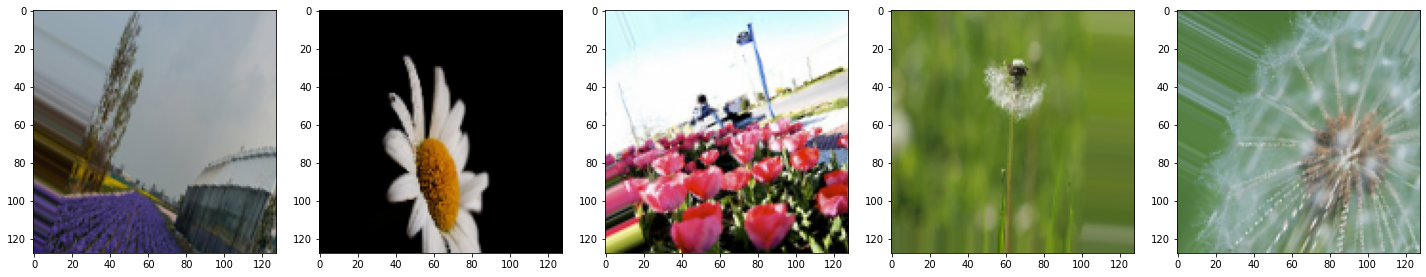

In [8]:
augmented_images = [train_data[0][0][i] for i in range(5)]
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for img, ax in zip(augmented_images, axes.flatten()):
    ax.imshow(img)
plt.tight_layout()
plt.show() 

In [9]:
valid_generator = ImageDataGenerator(rescale=1./255)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 865 images belonging to 5 classes.


# Model

In [10]:
model = tf.keras.models.Sequential([    
    # full parameter names for example
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
    ),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # dropout layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='softmax')
])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0

In [13]:
EPOCHS = 60
history = model.fit_generator(
    generator=train_data,
    steps_per_epoch=(train_data.n + BATCH_SIZE - 1) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=(valid_data.n + BATCH_SIZE - 1) // BATCH_SIZE,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-18 03:23:52.947975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60
27/27 [==============================] - 38s 1s/step - loss: 1.4830 - accuracy: 0.3662 - val_loss: 1.4049 - val_accuracy: 0.4254
Epoch 2/60
27/27 [==============================] - 37s 1s/step - loss: 1.1839 - accuracy: 0.5139 - val_loss: 1.2494 - val_accuracy: 0.5029
Epoch 3/60
27/27 [==============================] - 37s 1s/step - loss: 1.0793 - accuracy: 0.5585 - val_loss: 1.1654 - val_accuracy: 0.5549
Epoch 4/60
27/27 [==============================] - 36s 1s/step - loss: 1.0320 - accuracy: 0.5878 - val_loss: 1.1397 - val_accuracy: 0.5526
Epoch 5/60
27/27 [==============================] - 36s 1s/step - loss: 0.9723 - accuracy: 0.6196 - val_loss: 1.1323 - val_accuracy: 0.5688
Epoch 6/60
27/27 [==============================] - 36s 1s/step - loss: 0.9536 - accuracy: 0.6251 - val_loss: 1.2055 - val_accuracy: 0.5549
Epoch 7/60
27/27 [==============================] - 36s 1s/step - loss: 0.9009 - accuracy: 0.6495 - val_loss: 1.0795 - val_accuracy: 0.6012
Epoch 8/60
27/27 [==

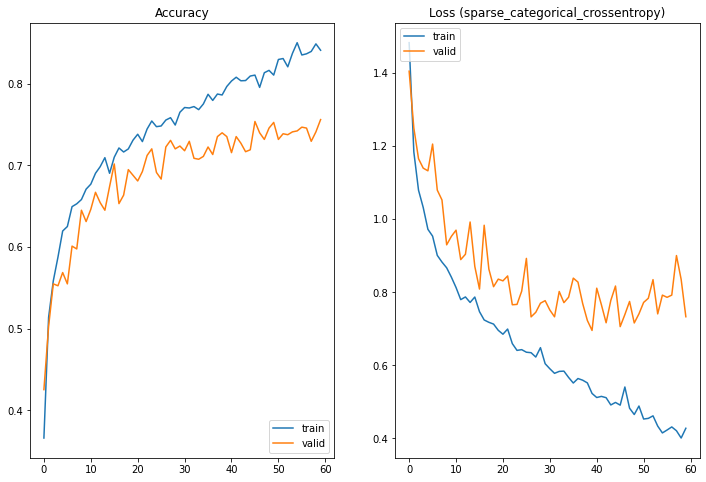

In [14]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='train')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='valid')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='train')
plt.plot(range(EPOCHS), history.history['val_loss'], label='valid')
plt.legend(loc='upper left')
plt.title('Loss (sparse_categorical_crossentropy)')

plt.show()